This notebook was created in kaggle, it can be used righ away loading the chest-xray-pneumonia dataset

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np
import os

# Check for GPU
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"Num GPUs Available: {num_gpus}")

# --- NEW: Distribution Strategy ---
if num_gpus > 1:
    strategy = tf.distribute.MirroredStrategy()
    print('Distribution strategy: MirroredStrategy (using multiple GPUs)')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0") # Or "/cpu:0" if no GPU
    print('Distribution strategy: OneDeviceStrategy (using a single GPU or CPU)')

Num GPUs Available: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Distribution strategy: MirroredStrategy (using multiple GPUs)


In [10]:
# Define parameters
IMG_SIZE = (224, 224)

# Since we have 2 GPUs, we can double the batch size for better efficiency.
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * num_gpus
LR = 0.001
EPOCHS = 50 # MAX

print(f"Using a global batch size of: {BATCH_SIZE}")

# Kaggle dataset paths
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

# Define Generators
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create Directory Iterators
train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Note: Use shuffle=False for reproducible evaluation
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# CONVERT TO tf.data.Dataset
# This wrapper handles the multi-GPU splitting logic safely
def tf_data_generator(generator, input_shape):
    num_classes = generator.num_classes
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *input_shape], [None, num_classes])
    )
    return dataset

# Wrap Train Set
train_dataset = tf_data_generator(train_gen, (IMG_SIZE[0], IMG_SIZE[1], 3))
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.repeat() # Loops indefinitely
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Wrap Validation Set
val_dataset = tf_data_generator(val_gen, (IMG_SIZE[0], IMG_SIZE[1], 3))
val_dataset = val_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Calculate Steps per Epoch (Since we use .repeat(), we must specify steps manually)
steps_per_epoch = train_gen.samples // BATCH_SIZE
validation_steps = val_gen.samples // BATCH_SIZE
# Calculate steps to cover the whole test set
test_steps = int(np.ceil(test_gen.samples / BATCH_SIZE))

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

# Class Weights (Recalculate)
train_classes = train_gen.classes
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = dict(enumerate(class_weights_vals))

Using a global batch size of: 64
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Steps per epoch: 65
Validation steps: 16
Test steps: 10


In [ ]:
# Wrap Model Definition and Compilation in the strategy scope
with strategy.scope():
    # Load model with ImageNet weights, excluding the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add the new classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # "Bottleneck" features
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Drops 50% of connections to prevent overfitting
    
    # --- L2 REGULARIZATION ADDED HERE ---
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x) 
    x = Dropout(0.5)(x)         
    
    # --- L2 REGULARIZATION ADDED HERE ---
    predictions = Dense(train_gen.num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    # The optimizer is initialized within the strategy scope
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Callbacks ---
# 1. Save the best model (Persist progress)
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/InceptionV3_pneumonia_best.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# 2. Stop early if no improvement
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',   # Watch validation accuracy
    patience=10,              # Stop if it doesn't improve for 10 epochs
    restore_best_weights=True # Go back to the best version automatically
)

# Put all callbacks into a list
callbacks_list = [checkpoint_callback, early_stopping_callback]

In [ ]:
# Train the model
print("Starting training on multiple GPUs...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Final Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)b
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Model final evaluation

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50

IMG_SIZE = (224, 224)
LR = 0.001
num_classes = 2      

with strategy.scope():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x) 
    x = Dropout(0.5)(x) 
    
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x) 
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    weights_path = '/kaggle/input/resnet50l2/tensorflow2/default/1/InceptionV3_pneumonia_best.weights.h5' 

    model.load_weights(weights_path) 
    print("✅ Successfully rebuilt architecture and loaded checkpoint weights.")

    model.compile(
        optimizer=Adam(learning_rate=LR),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    print("\nModel recompiled for evaluation")

✅ Successfully rebuilt architecture and loaded checkpoint weights.

Model recompiled for evaluation


In [34]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

def extract_data_from_generator(generator):
    """
    Extracts all image data (X_test) and true labels (y_test) from a Keras generator.

    This is necessary when the evaluation function requires the full NumPy arrays 
    instead of the generator object.

    Arguments:
        generator (keras.preprocessing.image.DirectoryIterator): The test generator 
            with shuffle=False.

    Returns:
        tuple: (X_data, y_labels), where X_data is the full array of images, 
               and y_labels is the full array of true integer labels.
    """
    print(f"Extracting {generator.samples} samples from the generator...")
    
    # 1. Reset the generator to ensure the file order is consistent from the start
    generator.reset()
    
    # 2. Calculate the number of batches to iterate over
    num_samples = generator.samples
    batch_size = generator.batch_size
    steps = int(np.ceil(num_samples / batch_size))
    
    X_list = []
    
    # 3. Iterate through all batches
    for i in range(steps):
        # Get the next batch
        X_batch, _ = next(generator)
        X_list.append(X_batch)
    
    # 4. Concatenate all batches into a single NumPy array
    X_data = np.concatenate(X_list, axis=0)
    
    # 5. Get the true integer labels (already stored by the generator)
    # Since class_mode='categorical' was used, generator.classes contains the 
    # integer labels (0 or 1). This matches the order because shuffle=False was used.
    y_labels = generator.classes
    
    # Trim X_data to match the exact number of samples (in case the last batch was padded/cut off)
    X_data = X_data[:num_samples]

    print("Extraction complete. X_test array is ready.")
    return X_data, y_labels

In [38]:
def evaluate_binary_model(model, X_test, y_test, threshold=0.5):
    """
    Calculates key performance metrics for a binary classification model.

    Arguments:
        model (tf.keras.Model): The trained Keras model.
        X_test (np.array): Input data (images) from the test set.
        y_test (np.array): True labels (0 or 1) from the test set.
        threshold (float): Threshold to convert probability outputs into binary classes.

    Returns:
        dict: A dictionary containing all calculated metrics and ROC curve data.
    """
    print("--- Model Performance Evaluation ---")

    # 1. Get probability predictions (output for the positive class)
    y_pred_proba = model.predict(X_test)

    # FIX 1: Ensure y_pred_proba is 1D for ROC calculation
    # If the model uses a softmax activation and has 2 output units (shape (N, 2)), 
    # we take the probability of the positive class (index 1).
    if y_pred_proba.ndim == 2 and y_pred_proba.shape[1] > 1:
        y_pred_proba = y_pred_proba[:, 1]
    
    # Flatten probabilities if the shape is (N, 1) or just a vector
    y_pred_proba = y_pred_proba.flatten()
    
    # 2. Convert probabilities to binary classes using the threshold
    y_pred_classes = (y_pred_proba >= threshold).astype(int)
    
    # FIX 2: Ensure y_test is a 1D array of integer labels (0 or 1)
    
    # Safety Step 1: Handle potential one-hot encoding (shape (N, 2))
    if y_test.ndim == 2 and y_test.shape[1] > 1:
        # Convert one-hot to integer labels (index of the highest probability)
        y_test = np.argmax(y_test, axis=1)
    
    # Safety Step 2: Ensure y_test is explicitly flattened and typed as integer
    y_test = y_test.flatten().astype(int)

    # FINAL FIX: Use squeeze() on both arrays to guarantee 1D shape (N,) before metrics
    y_test_final = np.squeeze(y_test)
    y_pred_classes_final = np.squeeze(y_pred_classes)

    # Diagnostic Prints before metric calculation
    print(f"y_test shape before metrics: {y_test_final.shape}")
    print(f"y_pred_classes shape before metrics: {y_pred_classes_final.shape}")

    # 3. Calculate Accuracy
    # Note: For official Loss, use model.evaluate() in the main notebook.
    accuracy = accuracy_score(y_test_final, y_pred_classes_final)
    print(f"Accuracy: {accuracy:.4f}")

    # 4. Confusion Matrix
    # Structure: [ [TN, FP], [FN, TP] ]
    cm = confusion_matrix(y_test_final, y_pred_classes_final)
    
    TN, FP, FN, TP = cm.ravel()
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # 5. Calculate derived metrics (Sensitivity, Specificity, etc.)

    # Sensitivity (Recall): Ability to correctly detect positive cases (Pneumonia)
    sensibility = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Specificity: Ability to correctly detect negative cases (Normal)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    # F1-Score: Harmonic mean of Precision and Recall (Useful for imbalanced data)
    precision_score = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision_score * sensibility) / (precision_score + sensibility) if (precision_score + sensibility) > 0 else 0

    print(f"\nSensitivity (Recall): {sensibility:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    
    # 6. ROC Curve (Receiver Operating Characteristic) and AUC
    
    # Ensure there are two unique classes
    if len(np.unique(y_test_final)) == 2:
        # Calculate ROC Curve data. Use the original y_pred_proba (1D)
        fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba)
        
        # Calculate Area Under the Curve (AUC)
        roc_auc = roc_auc_score(y_test_final, y_pred_proba)
        print(f"AUC (Area Under the Curve): {roc_auc:.4f}")
        
        # 7. Plot the ROC Curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('ROC Curve for Pneumonia Detection')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        roc_data = {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'auc': roc_auc}
    else:
        print("\nWarning: Could not calculate ROC Curve/AUC; at least two unique classes are required in y_test.")
        roc_data = None
        
    return {
        'accuracy': accuracy,
        'loss_note': "Use model.evaluate() for the official Keras loss value.",
        'confusion_matrix': cm.tolist(),
        'true_positives': int(TP),
        'true_negatives': int(TN),
        'false_positives': int(FP),
        'false_negatives': int(FN),
        'sensibility_recall': sensibility,
        'specificity': specificity,
        'f1_score': f1_score,
        'roc_data': roc_data
    }

In [32]:
X_test_real, y_test_real = extract_data_from_generator(test_gen)
X_test_real, y_test_real

Extracting 624 samples from the generator...
Extraction complete. X_test array is ready.


(array([[[[-7.1939003e+01, -8.4778999e+01, -9.1680000e+01],
          [-7.2939003e+01, -8.5778999e+01, -9.2680000e+01],
          [-7.1939003e+01, -8.4778999e+01, -9.1680000e+01],
          ...,
          [-7.1939003e+01, -8.4778999e+01, -9.1680000e+01],
          [-7.3939003e+01, -8.6778999e+01, -9.3680000e+01],
          [-6.8939003e+01, -8.1778999e+01, -8.8680000e+01]],
 
         [[-6.9939003e+01, -8.2778999e+01, -8.9680000e+01],
          [-7.0939003e+01, -8.3778999e+01, -9.0680000e+01],
          [-7.3939003e+01, -8.6778999e+01, -9.3680000e+01],
          ...,
          [-7.3939003e+01, -8.6778999e+01, -9.3680000e+01],
          [-7.0939003e+01, -8.3778999e+01, -9.0680000e+01],
          [-7.0939003e+01, -8.3778999e+01, -9.0680000e+01]],
 
         [[-7.0939003e+01, -8.3778999e+01, -9.0680000e+01],
          [-7.1939003e+01, -8.4778999e+01, -9.1680000e+01],
          [-7.0939003e+01, -8.3778999e+01, -9.0680000e+01],
          ...,
          [-7.1939003e+01, -8.4778999e+01, -9.168

--- Model Performance Evaluation ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
y_test shape before metrics: (624,)
y_pred_classes shape before metrics: (624,)
Accuracy: 0.9151

Confusion Matrix:
[[212  22]
 [ 31 359]]

Sensitivity (Recall): 0.9205
Specificity: 0.9060
F1 Score: 0.9313
AUC (Area Under the Curve): 0.9706


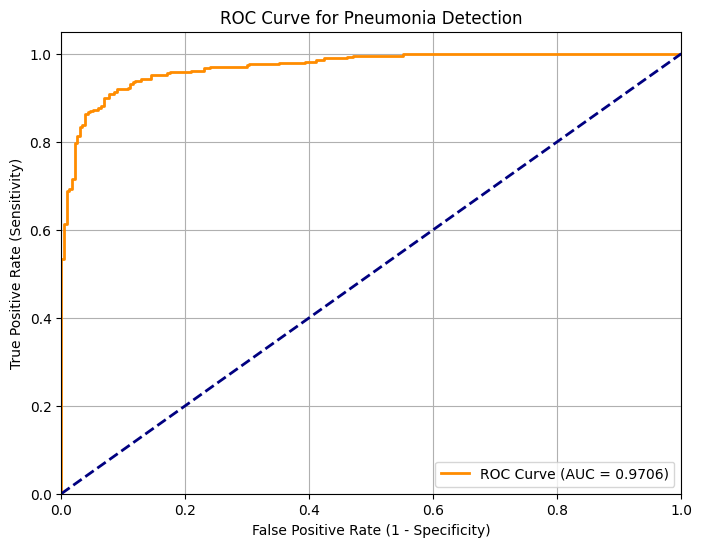

In [39]:
metrics_results = evaluate_binary_model(model, X_test_real, y_test_real)

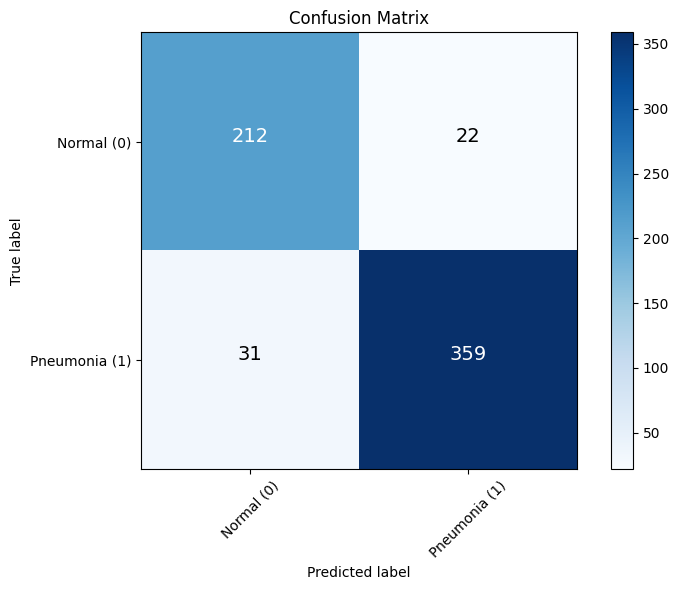

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names=['Normal (0)', 'Pneumonia (1)'], title='Confusion Matrix'):
    """Plots a confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    
    # Plot the matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    # Set tick labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add numbers inside the cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=14)

    plt.tight_layout()
    plt.show()

# Your hardcoded confusion matrix data:
HARDCODED_CM = np.array([[212, 22], [31, 359]])

# Call the function to plot the graph
plot_confusion_matrix(HARDCODED_CM)